✅ Modelo cargado: models\final_model_fold5.h5
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_6 (Sequential)      (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['sequential_6[0][0]']           
                                )                                                                 
                                              

Evaluando imágenes: 100%|██████████| 225/225 [02:25<00:00,  1.55img/s]


📊 Métricas medias:
  - Precision: 0.2055
  - Recall  : 0.0231
  - F1      : 0.0370
  - Iou     : 0.0195

🎨 Mostrando 3 muestras aleatorias…


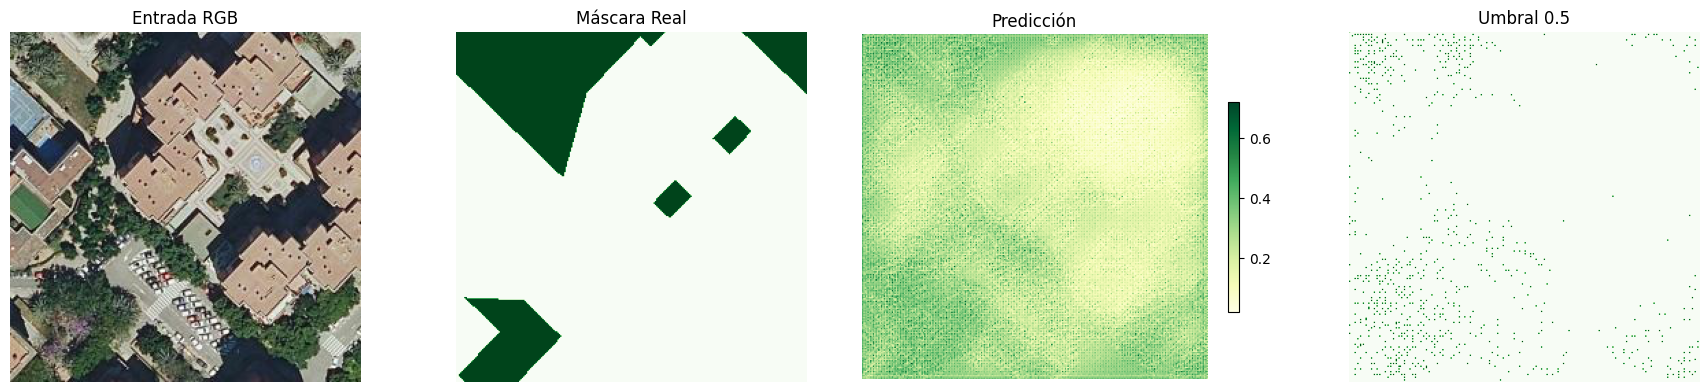

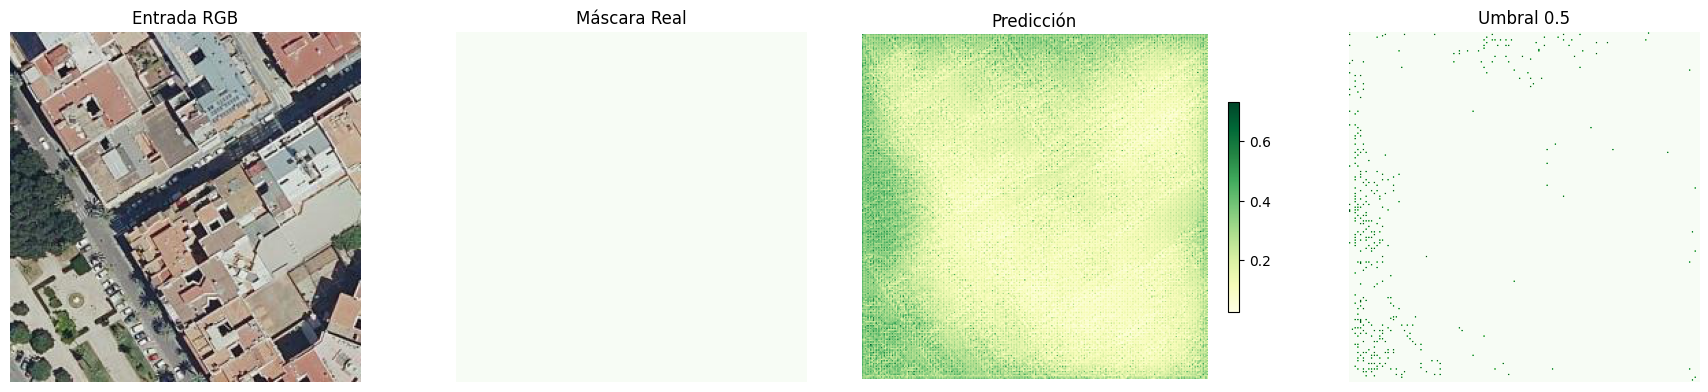

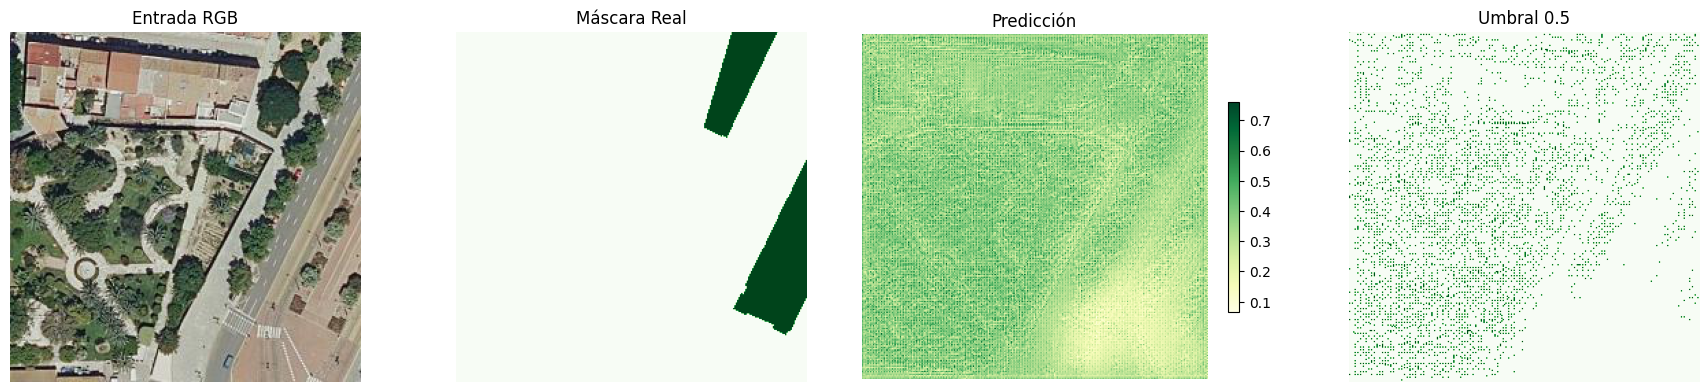

Threshold 0.3: Precision=0.306, Recall=0.677, IoU=0.267
Threshold 0.5: Precision=0.411, Recall=0.056, IoU=0.052
Threshold 0.7: Precision=0.454, Recall=0.000, IoU=0.000

✅ Informe guardado en evaluation_report.csv


In [1]:
# notebooks/05_Visualizar_Predicciones 

# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIG
# ------------------------------------------------------------------
from pathlib import Path
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import sys

import warnings
from rasterio.errors import NotGeoreferencedWarning
from tqdm import tqdm
# Suprimir solo los warnings de Rasterio
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Añadir scripts al path
PROJECT_ROOT = Path().resolve().parent
SCRIPT_DIR   = PROJECT_ROOT / "scripts"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.append(str(SCRIPT_DIR))

from model_utils import dice_loss

# ------------------------------------------------------------------
# 1. PATHS
# ------------------------------------------------------------------
RAW_DIR       = PROJECT_ROOT / "data" / "raw" / "pnoa"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_PATH    = PROJECT_ROOT / "models" / "final_model_fold5.h5"  # o final_model.h5 o best_model.h5

# ------------------------------------------------------------------
# 3. CARGAR MODELO
# ------------------------------------------------------------------
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'dice_loss': dice_loss},
    compile=False
)
print(f"✅ Modelo cargado: {MODEL_PATH.relative_to(PROJECT_ROOT)}")
model.summary()

# ------------------------------------------------------------------
# 4. UTILIDADES DE PREPROCESADO
# ------------------------------------------------------------------
def load_image_and_mask(tile_jpg: Path, target_size=(256,256)):
    """Carga JPEG y su máscara TIFF, normaliza a [0,1] y devuelve ambos."""
    mask_tif = PROCESSED_DIR / f"{tile_jpg.stem}_MASK.tif"
    assert mask_tif.exists(), f"Falta máscara para {tile_jpg.name}"
    # Leer JPEG
    with rasterio.open(tile_jpg) as src:
        img = src.read([1,2,3]).transpose(1,2,0).astype(np.float32)
    img = tf.image.resize(img, target_size) / 255.0
    # Leer máscara
    with rasterio.open(mask_tif) as src:
        msk = src.read(1).astype(np.uint8)
    msk = tf.image.resize(msk[...,None], target_size, method='nearest')
    msk = tf.squeeze(msk).numpy().astype(int)
    return img.numpy(), msk

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Precision, recall, F1 e IoU para dos arrays binarios."""
    y_t = y_true.flatten()
    y_p = (y_pred.flatten() > threshold).astype(int)
    return {
        "precision": precision_score(y_t, y_p, zero_division=0),
        "recall":    recall_score(y_t, y_p, zero_division=0),
        "f1":        f1_score(y_t, y_p, zero_division=0),
        "iou":       jaccard_score(y_t, y_p, zero_division=0)
    }

def plot_sample_prediction(img, msk, pred, threshold=0.5):
    """Muestra 4 paneles: entrada, máscara real, mapa de predicción, máscara umbral."""
    fig, axes = plt.subplots(1,4, figsize=(18,4))
    axes[0].imshow(img); axes[0].set_title("Entrada RGB");      axes[0].axis('off')
    axes[1].imshow(msk, cmap='Greens'); axes[1].set_title("Máscara Real"); axes[1].axis('off')
    im = axes[2].imshow(pred, cmap='YlGn'); axes[2].set_title("Predicción"); axes[2].axis('off')
    fig.colorbar(im, ax=axes[2], shrink=0.6)
    axes[3].imshow(pred>threshold, cmap='Greens')
    axes[3].set_title(f"Umbral {threshold}");    axes[3].axis('off')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 5. EVALUACIÓN GLOBAL
# ------------------------------------------------------------------
print("\n🧪 Evaluando todas las imágenes…")
all_metrics = []
predictions = []

jpgs = sorted(RAW_DIR.glob("valencia_tile_*.jpg"))
for tile in tqdm(jpgs, desc="Evaluando imágenes", unit="img"):
    img, msk = load_image_and_mask(tile)
    pred     = model.predict(img[None], verbose=0)[0,:,:,0]
    metrics  = calculate_metrics(msk, pred, threshold=0.5)
    all_metrics.append(metrics)
    predictions.append((img, msk, pred))

# Promediar métricas
avg = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
print("📊 Métricas medias:")
for k,v in avg.items():
    print(f"  - {k.capitalize():8s}: {v:.4f}")

# ------------------------------------------------------------------
# 6. VISUALIZAR EJEMPLOS
# ------------------------------------------------------------------
print(f"\n🎨 Mostrando 3 muestras aleatorias…")
import random
for img, msk, pred in random.sample(predictions, 3):
    plot_sample_prediction(img, msk, pred, threshold=0.5)

# ------------------------------------------------------------------
# 7. BALANCE DE THRESHOLDS (opcional)
# ------------------------------------------------------------------
# Puedes evaluar cómo varían las métricas con distintos umbrales:
thresholds = [0.3, 0.5, 0.7]
for t in thresholds:
    m = calculate_metrics(
        np.concatenate([msk.flatten() for _,msk,_ in predictions]),
        np.concatenate([pred.flatten() for _,_,pred in predictions]),
        threshold=t
    )
    print(f"Threshold {t}: Precision={m['precision']:.3f}, Recall={m['recall']:.3f}, IoU={m['iou']:.3f}")

# ------------------------------------------------------------------
# 8. Guardar informe a CSV
# ------------------------------------------------------------------
import pandas as pd
df = pd.DataFrame(all_metrics)
df.to_csv(PROJECT_ROOT/"evaluation_report.csv", index=False)
print(f"\n✅ Informe guardado en evaluation_report.csv")
